In [1]:
import paddle
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
print("PaddlePaddle is compiled with CUDA:", paddle.is_compiled_with_cuda())
print("PaddlePaddle is using GPU:", paddle.device.get_device())

True
NVIDIA GeForce RTX 3060 Laptop GPU
PaddlePaddle is compiled with CUDA: True
PaddlePaddle is using GPU: gpu:0


In [2]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

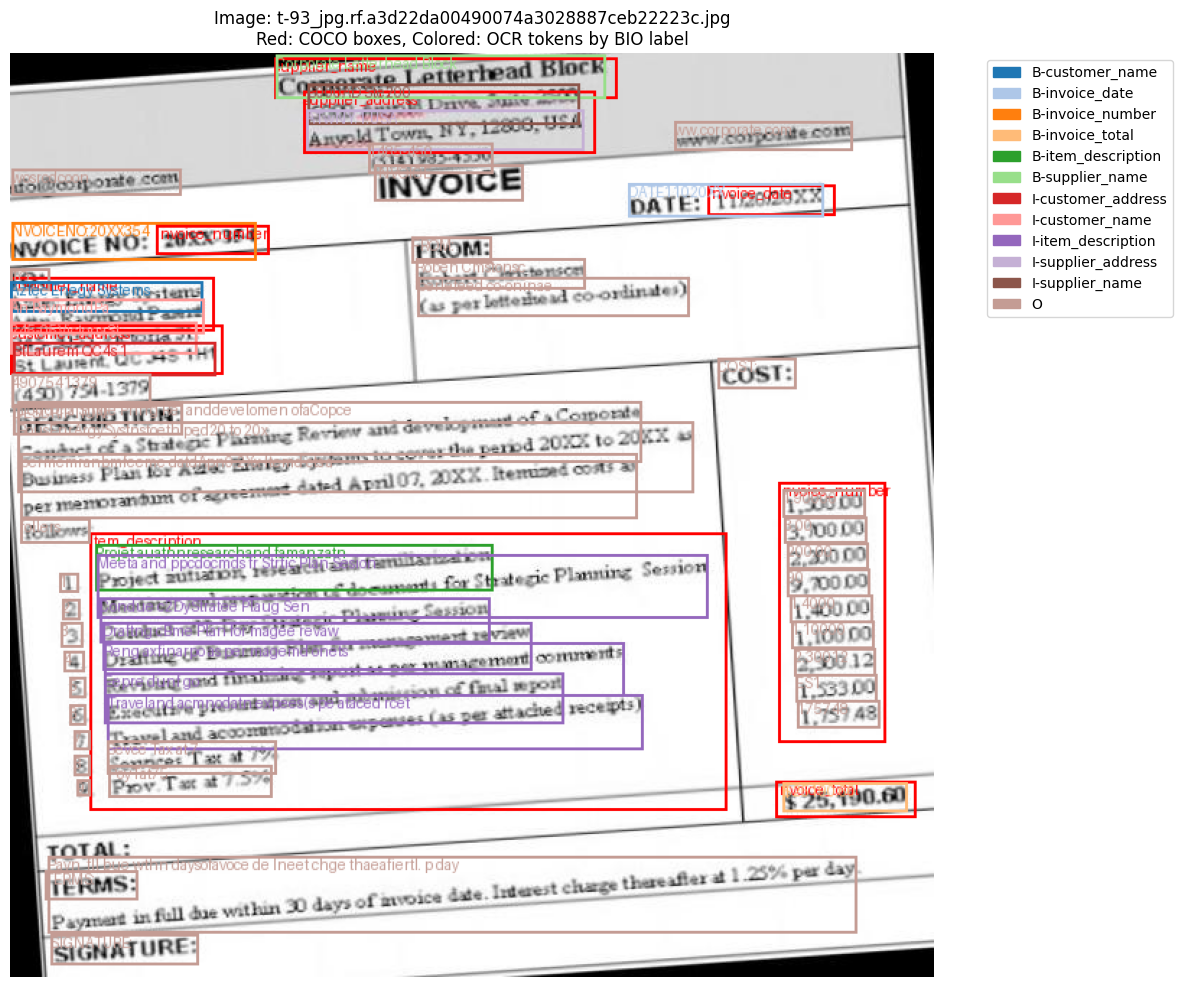

In [3]:
import os
import json
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURATION ---
train_img_dir = "../data/invoices-8/train"
coco_ann_path = "../data/invoices-8/train/_annotations.coco.json"
jsonl_path = "../data/invoices-8/layoutlmv3_train.jsonl"

# --- LOAD COCO ANNOTATIONS ---
with open(coco_ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)
img_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
filename_to_img_id = {v: k for k, v in img_id_to_filename.items()}
img_id_to_anns = {}
for ann in coco["annotations"]:
    img_id_to_anns.setdefault(ann["image_id"], []).append(ann)
cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

# --- LOAD JSONL (OCR tokens and BIO labels) ---
with open(jsonl_path, "r", encoding="utf-8") as f:
    jsonl_examples = [json.loads(line) for line in f]

# --- PICK RANDOM EXAMPLE ---
example = random.choice(jsonl_examples)
img_filename = example["file_name"] if "file_name" in example else example.get("image_path", None)
if img_filename is None:
    # Try to infer from tokens or fallback
    img_filename = os.path.basename(example["image"]) if "image" in example else None
assert img_filename is not None, "Could not determine image filename from JSONL example."

img_path = os.path.join(train_img_dir, img_filename)
img_id = filename_to_img_id.get(img_filename)
assert img_id is not None, f"Image id not found for {img_filename}"

# --- LOAD IMAGE ---
image = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(image)

# --- PLOT COCO ANNOTATION BOXES ---
anns = img_id_to_anns.get(img_id, [])
for ann in anns:
    x, y, w, h = ann["bbox"]
    rect = [x, y, x + w, y + h]
    draw.rectangle(rect, outline="red", width=2)
    cat_name = cat_id_to_name.get(ann["category_id"], "unknown")
    draw.text((x, y), cat_name, fill="red")

# --- PLOT OCR TOKENS COLORED BY BIO LABEL ---
tokens = example["tokens"]
bboxes = example["bboxes"]
labels = example["labels"]

# Define a color map for BIO labels
import matplotlib
unique_labels = sorted(set(labels))
label_colors = {l: matplotlib.colors.to_hex(plt.cm.tab20(i % 20)) for i, l in enumerate(unique_labels)}

for token, bbox, label in zip(tokens, bboxes, labels):
    # bbox is [x0, y0, x1, y1] in 0-1000 normalized coordinates
    x0, y0, x1, y1 = [int(v * image.width / 1000) if i % 2 == 0 else int(v * image.height / 1000) for i, v in enumerate(bbox)]
    color = label_colors[label]
    draw.rectangle([x0, y0, x1, y1], outline=color, width=2)
    draw.text((x0, y0), token, fill=color)

# --- SHOW LEGEND ---
plt.figure(figsize=(12, 12))
plt.imshow(image)
legend_patches = [patches.Patch(color=label_colors[l], label=l) for l in unique_labels]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.title(f"Image: {img_filename}\nRed: COCO boxes, Colored: OCR tokens by BIO label")
plt.show()

In [4]:
from collections import defaultdict, Counter
import json

def compute_region_coverage(jsonl_path, coco_path):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        jsonl_examples = [json.loads(line) for line in f]

    with open(coco_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    img_id_to_anns = defaultdict(list)
    for ann in coco["annotations"]:
        img_id_to_anns[ann["image_id"]].append(ann)

    filename_to_img_id = {img["file_name"]: img["id"] for img in coco["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

    total_regions = 0
    total_missed = 0

    print("Region Coverage Report")
    print("="*60)
    for ex in jsonl_examples:
        fname = ex["file_name"]
        labels = ex["labels"]
        img_id = filename_to_img_id[fname]
        anns = img_id_to_anns.get(img_id, [])
        coco_labels = [cat_id_to_name[a["category_id"]] for a in anns]
        tagged_cats = set(l.split("-")[-1] for l in labels if l != "O" and "-" in l)
        missed = set(coco_labels) - tagged_cats

        total_regions += len(coco_labels)
        total_missed += len(missed)

        percent_missed = (len(missed) / len(coco_labels) * 100) if coco_labels else 0
        # print(f"Image: {fname}")
        # print(f"  - COCO regions: {len(coco_labels)}")
        # print(f"  - Missed regions: {len(missed)} ({percent_missed:.1f}%) {missed if missed else ''}")

    overall_miss_rate = (total_missed / total_regions * 100) if total_regions else 0
    print("="*60)
    print(f"Overall missed regions: {total_missed} / {total_regions} ({overall_miss_rate:.1f}%)")

# Example usage:
compute_region_coverage(
    jsonl_path="../data/invoices-8/layoutlmv3_train.jsonl",
    coco_path="../data/invoices-8/train/_annotations.coco.json"
)

Region Coverage Report
Overall missed regions: 802 / 3576 (22.4%)


# LayoutLMv3 Training Script for Invoice Data Extraction

In [5]:
from datasets import load_dataset
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor, TrainingArguments, Trainer
import torch

# Load train and validation splits from their respective JSONL files
data_files = {
    "train": "../data/invoices-8/layoutlmv3_train.jsonl",
    "validation": "../data/invoices-8/layoutlmv3_valid.jsonl"
}
dataset = load_dataset("json", data_files=data_files)
print(f"Train samples: {len(dataset['train'])}, Validation samples: {len(dataset['validation'])}")

# Build label list from your data
labels = sorted({label for split in ['train', 'validation'] for example in dataset[split] for label in example['labels']})
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

# Load processor and model
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

Train samples: 282, Validation samples: 29


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task 

In [6]:
# Compute class weights to address label imbalance
from collections import Counter

# Count all labels from both train and validation splits
all_labels = [l for split in ['train', 'validation'] for example in dataset[split] for l in example['labels']]
label_counts = Counter(all_labels)
print("Label counts:", label_counts)

total = sum(label_counts.values())
class_weights = {}
for l in labels:
    count = label_counts[l]
    if count == 0:
        class_weights[label2id[l]] = 0.0  # Avoid division by zero, or set to a small value if preferred
    else:
        class_weights[label2id[l]] = total / (len(labels) * count)
print("Class weights:", class_weights)

# Convert to tensor for use in loss
import torch
# Ensure weights_tensor is on the same device as model parameters during training
weights_tensor = torch.tensor([class_weights[i] for i in range(len(labels))], dtype=torch.float)
# Use the same device as the model
try:
    device = model.device
except Exception:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_tensor = weights_tensor.to(device)


Label counts: Counter({'O': 8682, 'B-invoice_total': 300, 'B-supplier_name': 296, 'B-invoice_date': 270, 'B-invoice_number': 260, 'B-customer_name': 250, 'B-invoice_subtotal': 231, 'I-item_description': 224, 'B-customer_address': 221, 'I-item_total_price': 200, 'I-customer_address': 194, 'B-item_description': 185, 'I-item_unit_price': 183, 'B-supplier_address': 175, 'B-item_total_price': 170, 'B-tax_amount': 167, 'B-tax_rate': 161, 'B-item_unit_price': 150, 'I-supplier_address': 136, 'B-due_date': 113, 'B-item_quantity': 78, 'I-supplier_name': 67, 'I-item_quantity': 40, 'I-customer_name': 28, 'I-due_date': 5, 'I-invoice_date': 5, 'I-invoice_total': 3, 'I-tax_amount': 1, 'I-invoice_number': 1})
Class weights: {0: 1.9965673271961304, 1: 1.7649655172413794, 2: 3.9047909673481844, 3: 1.634227330779055, 4: 1.6970822281167108, 5: 1.910135841170324, 6: 1.4708045977011495, 7: 2.385088536812675, 8: 5.656940760389036, 9: 2.5955375253549695, 10: 2.941609195402299, 11: 2.5213793103448277, 12: 1.49

In [7]:
# Verify bounding box format and normalization
# Each bbox should be [x0, y0, x1, y1] and all values in 0-1000

def check_bbox_format(dataset):
    sample = dataset["train"][0]
    bboxes = sample["bboxes"]
    for bbox in bboxes[:5]:  # check first 5 bboxes
        assert len(bbox) == 4, f"Bbox should have 4 elements, got {bbox}"
        assert all(0 <= v <= 1000 for v in bbox), f"Bbox values out of range: {bbox}"
    print("Sample bboxes (first 5):", bboxes[:5])
    print("Bounding box format and normalization look correct.")

check_bbox_format(dataset)


Sample bboxes (first 5): [[604, 28, 854, 64], [25, 31, 338, 65], [84, 83, 174, 103], [599, 86, 757, 105], [598, 101, 857, 125]]
Bounding box format and normalization look correct.


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file_name', 'tokens', 'bboxes', 'labels'],
        num_rows: 282
    })
    validation: Dataset({
        features: ['file_name', 'tokens', 'bboxes', 'labels'],
        num_rows: 29
    })
})

In [9]:
import numpy as np
# Preprocessing function for the dataset
def preprocess(example):
    encoding = processor.tokenizer(
        example["tokens"],
        boxes=example["bboxes"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    # Pad labels to max_length
    labels = [label2id[l] for l in example["labels"]]
    labels = labels + [-100] * (512 - len(labels))
    encoding["labels"] = torch.tensor(labels)
    # Print keys for debugging
    # print(f"Encoding keys: {list(encoding.keys())}")
    return encoding

# Apply preprocessing
dataset = dataset.map(preprocess, batched=False)
# Print a sample to check keys
print(dataset["train"][0])

Map:   0%|          | 0/282 [00:00<?, ? examples/s]

Map:   0%|          | 0/29 [00:00<?, ? examples/s]

{'file_name': 't-18_jpg.rf.e70a4507b24d2d4cccd5045ca61dd4df.jpg', 'tokens': ['FACTURE', 'NOMDESTE', 'Telephone', 'Ndcfactureld-101', 'Datc.defacturation24/09/2020', 'Info@facture-excel.com', 'Echeance14/10/2020', 'Ville,Pays', 'www.facture-excel.com', 'Envoyea', 'Facture', 'Jhon.doa', 'Jhon doe', 'drsxxxxxxxxxxxxxxx', 'adressex', 'MONTANT', 'PRIX UNIT', 'DESIGNATION', 'QTE', '3150,00', '350,00', '9', 'Article', '840,00', '120,00', 'Article', '7', '2880,00', '360,00', 'Article', '8', '27.00', '3,00', 'Article', '6', '225,00', '15,00', 'Article', '15', '100,00', '0,50', '200', 'Article', '7222,00', 'MONTANT HT', '1011,08', '14%', 'TVA', '8233,08', 'TOTALTTC', 'Lepicment estdudans 30jours', 'TELE0000S-G-06-05FAX000-00-0D-CO', 'NFR151265957SWIFT/BC0XX', 'Merd de Vatre Conliance'], 'bboxes': [[604, 28, 854, 64], [25, 31, 338, 65], [84, 83, 174, 103], [599, 86, 757, 105], [598, 101, 857, 125], [83, 112, 284, 133], [600, 122, 778, 140], [84, 145, 173, 165], [84, 173, 283, 194], [543, 243, 644

In [10]:
# Set format for PyTorch
dataset.set_format(type="torch", columns=["input_ids", "bbox", "attention_mask", "labels"])

In [11]:
from datasets import load_metric

# Define compute_metrics for sequence labeling (BIO tagging)
metric = load_metric("seqeval")

label_list = labels  # already sorted and used for label2id/id2label

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lab] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    # Prefix all metrics with 'eval_' to match Trainer expectations
    return {
        "eval_precision": results["overall_precision"],
        "eval_recall": results["overall_recall"],
        "eval_f1": results["overall_f1"],
        "eval_accuracy": results["overall_accuracy"]
    }

C:\Users\Haythem\AppData\Local\Temp\ipykernel_19944\3245775408.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\projects\extracteur_de_factures\venv311\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code whic

In [12]:
# Custom Trainer to use class weights in loss
from transformers import Trainer

class WeightedTrainer(Trainer):
    def __init__(self, *args, weights_tensor=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.weights_tensor = weights_tensor

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move weights_tensor to the same device as logits
        weights = self.weights_tensor.to(logits.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights, ignore_index=-100)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Lower learning rate and increase epochs
from transformers import TrainingArguments
args = TrainingArguments(
    output_dir="./layoutlmv3-invoice",
    per_device_train_batch_size=2,
    num_train_epochs=15,  # Increase epochs
    learning_rate=5e-5,   # Lower learning rate
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=100,
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    fp16=True
)


In [13]:
# Trainer setup
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
    weights_tensor=weights_tensor  # Pass class weights to the trainer
)

# Start training
trainer.train()

  0%|          | 0/2115 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 3.3015, 'grad_norm': 7.339060306549072, 'learning_rate': 4.976359338061466e-05, 'epoch': 0.07}
{'loss': 3.3245, 'grad_norm': 3.4457125663757324, 'learning_rate': 4.9527186761229313e-05, 'epoch': 0.14}
{'loss': 3.3245, 'grad_norm': 3.4457125663757324, 'learning_rate': 4.9527186761229313e-05, 'epoch': 0.14}
{'loss': 3.207, 'grad_norm': 4.428173065185547, 'learning_rate': 4.929078014184397e-05, 'epoch': 0.21}
{'loss': 3.207, 'grad_norm': 4.428173065185547, 'learning_rate': 4.929078014184397e-05, 'epoch': 0.21}
{'loss': 3.4048, 'grad_norm': 7.75575590133667, 'learning_rate': 4.905437352245863e-05, 'epoch': 0.28}
{'loss': 3.4048, 'grad_norm': 7.75575590133667, 'learning_rate': 4.905437352245863e-05, 'epoch': 0.28}
{'loss': 3.281, 'grad_norm': 4.097054958343506, 'learning_rate': 4.8817966903073283e-05, 'epoch': 0.35}
{'loss': 3.281, 'grad_norm': 4.097054958343506, 'learning_rate': 4.8817966903073283e-05, 'epoch': 0.35}
{'loss': 3.0509, 'grad_norm': 8.300945281982422, 'learning_rate'

  0%|          | 0/4 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_precision': 0.08487084870848709, 'eval_recall': 0.12041884816753927, 'eval_f1': 0.09956709956709957, 'eval_accuracy': 0.07211538461538461, 'eval_loss': 3.2153964042663574, 'eval_runtime': 0.8316, 'eval_samples_per_second': 34.871, 'eval_steps_per_second': 4.81, 'epoch': 0.71}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 2.7411, 'grad_norm': 6.018208980560303, 'learning_rate': 4.7423167848699766e-05, 'epoch': 0.78}
{'loss': 2.7649, 'grad_norm': 5.642646312713623, 'learning_rate': 4.7186761229314425e-05, 'epoch': 0.85}
{'loss': 2.7649, 'grad_norm': 5.642646312713623, 'learning_rate': 4.7186761229314425e-05, 'epoch': 0.85}
{'loss': 2.7663, 'grad_norm': 4.112123012542725, 'learning_rate': 4.6950354609929084e-05, 'epoch': 0.92}
{'loss': 2.7663, 'grad_norm': 4.112123012542725, 'learning_rate': 4.6950354609929084e-05, 'epoch': 0.92}
{'loss': 3.1202, 'grad_norm': 16.861583709716797, 'learning_rate': 4.6713947990543736e-05, 'epoch': 0.99}
{'loss': 3.1202, 'grad_norm': 16.861583709716797, 'learning_rate': 4.6713947990543736e-05, 'epoch': 0.99}
{'loss': 2.6156, 'grad_norm': 6.083570957183838, 'learning_rate': 4.6477541371158395e-05, 'epoch': 1.06}
{'loss': 2.6156, 'grad_norm': 6.083570957183838, 'learning_rate': 4.6477541371158395e-05, 'epoch': 1.06}
{'loss': 3.0165, 'grad_norm': 5.015951633453369, 'lea

  0%|          | 0/4 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_precision': 0.05668934240362812, 'eval_recall': 0.13089005235602094, 'eval_f1': 0.0791139240506329, 'eval_accuracy': 0.044070512820512824, 'eval_loss': 3.373997211456299, 'eval_runtime': 0.7319, 'eval_samples_per_second': 39.624, 'eval_steps_per_second': 5.465, 'epoch': 1.42}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 2.5806, 'grad_norm': 4.915780067443848, 'learning_rate': 4.5059101654846335e-05, 'epoch': 1.49}
{'loss': 2.797, 'grad_norm': 5.362177848815918, 'learning_rate': 4.4822695035460994e-05, 'epoch': 1.56}
{'loss': 2.797, 'grad_norm': 5.362177848815918, 'learning_rate': 4.4822695035460994e-05, 'epoch': 1.56}
{'loss': 2.5208, 'grad_norm': 5.968373775482178, 'learning_rate': 4.458628841607565e-05, 'epoch': 1.63}
{'loss': 2.5208, 'grad_norm': 5.968373775482178, 'learning_rate': 4.458628841607565e-05, 'epoch': 1.63}
{'loss': 2.464, 'grad_norm': 19.963245391845703, 'learning_rate': 4.4349881796690305e-05, 'epoch': 1.7}
{'loss': 2.464, 'grad_norm': 19.963245391845703, 'learning_rate': 4.4349881796690305e-05, 'epoch': 1.7}
{'loss': 2.6624, 'grad_norm': 9.321310997009277, 'learning_rate': 4.411347517730497e-05, 'epoch': 1.77}
{'loss': 2.6624, 'grad_norm': 9.321310997009277, 'learning_rate': 4.411347517730497e-05, 'epoch': 1.77}
{'loss': 2.6748, 'grad_norm': 4.995128154754639, 'learning_rate

  0%|          | 0/4 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_precision': 0.03659976387249114, 'eval_recall': 0.08115183246073299, 'eval_f1': 0.05044751830756713, 'eval_accuracy': 0.049679487179487176, 'eval_loss': 3.1591601371765137, 'eval_runtime': 0.7323, 'eval_samples_per_second': 39.602, 'eval_steps_per_second': 5.462, 'epoch': 2.13}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 2.45, 'grad_norm': 6.512282371520996, 'learning_rate': 4.2718676122931446e-05, 'epoch': 2.2}
{'loss': 2.4347, 'grad_norm': 8.116556167602539, 'learning_rate': 4.2482269503546105e-05, 'epoch': 2.27}
{'loss': 2.4347, 'grad_norm': 8.116556167602539, 'learning_rate': 4.2482269503546105e-05, 'epoch': 2.27}
{'loss': 2.4499, 'grad_norm': 13.34687614440918, 'learning_rate': 4.224586288416076e-05, 'epoch': 2.34}
{'loss': 2.4499, 'grad_norm': 13.34687614440918, 'learning_rate': 4.224586288416076e-05, 'epoch': 2.34}
{'loss': 2.737, 'grad_norm': 6.005831241607666, 'learning_rate': 4.2009456264775416e-05, 'epoch': 2.41}
{'loss': 2.737, 'grad_norm': 6.005831241607666, 'learning_rate': 4.2009456264775416e-05, 'epoch': 2.41}
{'loss': 2.6191, 'grad_norm': 9.107770919799805, 'learning_rate': 4.1773049645390075e-05, 'epoch': 2.48}
{'loss': 2.6191, 'grad_norm': 9.107770919799805, 'learning_rate': 4.1773049645390075e-05, 'epoch': 2.48}
{'loss': 2.306, 'grad_norm': 14.483220100402832, 'learning_rat

  0%|          | 0/4 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_precision': 0.058823529411764705, 'eval_recall': 0.1518324607329843, 'eval_f1': 0.0847953216374269, 'eval_accuracy': 0.06009615384615385, 'eval_loss': 3.0585105419158936, 'eval_runtime': 0.7295, 'eval_samples_per_second': 39.752, 'eval_steps_per_second': 5.483, 'epoch': 2.84}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 2.2967, 'grad_norm': 13.420018196105957, 'learning_rate': 4.035460992907802e-05, 'epoch': 2.91}
{'loss': 2.2668, 'grad_norm': 6.779126167297363, 'learning_rate': 4.0118203309692674e-05, 'epoch': 2.98}
{'loss': 2.2668, 'grad_norm': 6.779126167297363, 'learning_rate': 4.0118203309692674e-05, 'epoch': 2.98}
{'loss': 2.2256, 'grad_norm': 6.850006580352783, 'learning_rate': 3.988179669030733e-05, 'epoch': 3.05}
{'loss': 2.2256, 'grad_norm': 6.850006580352783, 'learning_rate': 3.988179669030733e-05, 'epoch': 3.05}
{'loss': 2.1508, 'grad_norm': 11.86033821105957, 'learning_rate': 3.964539007092199e-05, 'epoch': 3.12}
{'loss': 2.1508, 'grad_norm': 11.86033821105957, 'learning_rate': 3.964539007092199e-05, 'epoch': 3.12}
{'loss': 2.3647, 'grad_norm': 8.629521369934082, 'learning_rate': 3.9408983451536644e-05, 'epoch': 3.19}
{'loss': 2.3647, 'grad_norm': 8.629521369934082, 'learning_rate': 3.9408983451536644e-05, 'epoch': 3.19}
{'loss': 2.2149, 'grad_norm': 10.55971622467041, 'learning_

  0%|          | 0/4 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_precision': 0.06172839506172839, 'eval_recall': 0.15706806282722513, 'eval_f1': 0.08862629246676514, 'eval_accuracy': 0.060897435897435896, 'eval_loss': 3.065735340118408, 'eval_runtime': 0.7367, 'eval_samples_per_second': 39.365, 'eval_steps_per_second': 5.43, 'epoch': 3.55}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 2.008, 'grad_norm': 4.737988471984863, 'learning_rate': 3.799054373522459e-05, 'epoch': 3.62}
{'loss': 2.2695, 'grad_norm': 4.919017791748047, 'learning_rate': 3.775413711583924e-05, 'epoch': 3.69}
{'loss': 2.2695, 'grad_norm': 4.919017791748047, 'learning_rate': 3.775413711583924e-05, 'epoch': 3.69}
{'loss': 2.6712, 'grad_norm': 10.538832664489746, 'learning_rate': 3.75177304964539e-05, 'epoch': 3.76}
{'loss': 2.6712, 'grad_norm': 10.538832664489746, 'learning_rate': 3.75177304964539e-05, 'epoch': 3.76}
{'loss': 2.1231, 'grad_norm': 12.97217082977295, 'learning_rate': 3.728132387706856e-05, 'epoch': 3.83}
{'loss': 2.1231, 'grad_norm': 12.97217082977295, 'learning_rate': 3.728132387706856e-05, 'epoch': 3.83}
{'loss': 2.132, 'grad_norm': 6.602646827697754, 'learning_rate': 3.704491725768321e-05, 'epoch': 3.9}
{'loss': 2.132, 'grad_norm': 6.602646827697754, 'learning_rate': 3.704491725768321e-05, 'epoch': 3.9}
{'loss': 2.3169, 'grad_norm': 9.689281463623047, 'learning_rate': 3.6

  0%|          | 0/4 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv311\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_precision': 0.0652395514780836, 'eval_recall': 0.16753926701570682, 'eval_f1': 0.09391049156272929, 'eval_accuracy': 0.09054487179487179, 'eval_loss': 3.127285957336426, 'eval_runtime': 0.7376, 'eval_samples_per_second': 39.317, 'eval_steps_per_second': 5.423, 'epoch': 4.26}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 2.1228, 'grad_norm': 8.49686050415039, 'learning_rate': 3.5650118203309695e-05, 'epoch': 4.33}
{'loss': 2.1196, 'grad_norm': 13.539701461791992, 'learning_rate': 3.5413711583924354e-05, 'epoch': 4.4}
{'loss': 2.1196, 'grad_norm': 13.539701461791992, 'learning_rate': 3.5413711583924354e-05, 'epoch': 4.4}
{'loss': 2.3231, 'grad_norm': 21.46187400817871, 'learning_rate': 3.517730496453901e-05, 'epoch': 4.47}
{'loss': 2.3231, 'grad_norm': 21.46187400817871, 'learning_rate': 3.517730496453901e-05, 'epoch': 4.47}
{'loss': 2.2944, 'grad_norm': 10.4463529586792, 'learning_rate': 3.4940898345153665e-05, 'epoch': 4.54}
{'loss': 2.2944, 'grad_norm': 10.4463529586792, 'learning_rate': 3.4940898345153665e-05, 'epoch': 4.54}
{'loss': 1.8861, 'grad_norm': 5.74444055557251, 'learning_rate': 3.4704491725768324e-05, 'epoch': 4.61}
{'loss': 1.8861, 'grad_norm': 5.74444055557251, 'learning_rate': 3.4704491725768324e-05, 'epoch': 4.61}
{'loss': 1.9587, 'grad_norm': 9.173771858215332, 'learning_rat

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.060851926977687626, 'eval_recall': 0.15706806282722513, 'eval_f1': 0.08771929824561403, 'eval_accuracy': 0.07051282051282051, 'eval_loss': 3.1037840843200684, 'eval_runtime': 0.7361, 'eval_samples_per_second': 39.399, 'eval_steps_per_second': 5.434, 'epoch': 4.96}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.7039, 'grad_norm': 7.847076416015625, 'learning_rate': 3.3286052009456264e-05, 'epoch': 5.04}
{'loss': 1.639, 'grad_norm': 13.005451202392578, 'learning_rate': 3.304964539007092e-05, 'epoch': 5.11}
{'loss': 1.639, 'grad_norm': 13.005451202392578, 'learning_rate': 3.304964539007092e-05, 'epoch': 5.11}
{'loss': 1.851, 'grad_norm': 9.690448760986328, 'learning_rate': 3.2813238770685575e-05, 'epoch': 5.18}
{'loss': 1.851, 'grad_norm': 9.690448760986328, 'learning_rate': 3.2813238770685575e-05, 'epoch': 5.18}
{'loss': 1.73, 'grad_norm': 7.582944869995117, 'learning_rate': 3.257683215130024e-05, 'epoch': 5.25}
{'loss': 1.73, 'grad_norm': 7.582944869995117, 'learning_rate': 3.257683215130024e-05, 'epoch': 5.25}
{'loss': 1.7165, 'grad_norm': 29.72550392150879, 'learning_rate': 3.23404255319149e-05, 'epoch': 5.32}
{'loss': 1.7165, 'grad_norm': 29.72550392150879, 'learning_rate': 3.23404255319149e-05, 'epoch': 5.32}
{'loss': 1.6414, 'grad_norm': 9.490018844604492, 'learning_rate': 3.2

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.05273833671399594, 'eval_recall': 0.13612565445026178, 'eval_f1': 0.07602339181286549, 'eval_accuracy': 0.0673076923076923, 'eval_loss': 3.170769214630127, 'eval_runtime': 0.7512, 'eval_samples_per_second': 38.603, 'eval_steps_per_second': 5.325, 'epoch': 5.67}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.9008, 'grad_norm': 15.164042472839355, 'learning_rate': 3.0945626477541375e-05, 'epoch': 5.74}
{'loss': 1.7662, 'grad_norm': 10.508033752441406, 'learning_rate': 3.070921985815603e-05, 'epoch': 5.82}
{'loss': 1.7662, 'grad_norm': 10.508033752441406, 'learning_rate': 3.070921985815603e-05, 'epoch': 5.82}
{'loss': 1.7737, 'grad_norm': 6.936829566955566, 'learning_rate': 3.0472813238770686e-05, 'epoch': 5.89}
{'loss': 1.7737, 'grad_norm': 6.936829566955566, 'learning_rate': 3.0472813238770686e-05, 'epoch': 5.89}
{'loss': 1.7766, 'grad_norm': 12.16598892211914, 'learning_rate': 3.0236406619385342e-05, 'epoch': 5.96}
{'loss': 1.7766, 'grad_norm': 12.16598892211914, 'learning_rate': 3.0236406619385342e-05, 'epoch': 5.96}
{'loss': 1.5834, 'grad_norm': 6.573354244232178, 'learning_rate': 3e-05, 'epoch': 6.03}
{'loss': 1.5834, 'grad_norm': 6.573354244232178, 'learning_rate': 3e-05, 'epoch': 6.03}
{'loss': 1.4782, 'grad_norm': 6.229028701782227, 'learning_rate': 2.9763593380614656e-05

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.06048780487804878, 'eval_recall': 0.16230366492146597, 'eval_f1': 0.08813077469793888, 'eval_accuracy': 0.07291666666666667, 'eval_loss': 3.1300337314605713, 'eval_runtime': 0.7386, 'eval_samples_per_second': 39.262, 'eval_steps_per_second': 5.416, 'epoch': 6.38}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.5978, 'grad_norm': 7.121098041534424, 'learning_rate': 2.8581560283687948e-05, 'epoch': 6.45}
{'loss': 1.405, 'grad_norm': 9.27906608581543, 'learning_rate': 2.8345153664302603e-05, 'epoch': 6.52}
{'loss': 1.405, 'grad_norm': 9.27906608581543, 'learning_rate': 2.8345153664302603e-05, 'epoch': 6.52}
{'loss': 1.3522, 'grad_norm': 7.047253131866455, 'learning_rate': 2.8108747044917262e-05, 'epoch': 6.6}
{'loss': 1.3522, 'grad_norm': 7.047253131866455, 'learning_rate': 2.8108747044917262e-05, 'epoch': 6.6}
{'loss': 1.5558, 'grad_norm': 8.98756217956543, 'learning_rate': 2.7872340425531918e-05, 'epoch': 6.67}
{'loss': 1.5558, 'grad_norm': 8.98756217956543, 'learning_rate': 2.7872340425531918e-05, 'epoch': 6.67}
{'loss': 1.6414, 'grad_norm': 23.463851928710938, 'learning_rate': 2.7635933806146573e-05, 'epoch': 6.74}
{'loss': 1.6414, 'grad_norm': 23.463851928710938, 'learning_rate': 2.7635933806146573e-05, 'epoch': 6.74}
{'loss': 1.7228, 'grad_norm': 10.512237548828125, 'learning_r

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.06879361914257229, 'eval_recall': 0.1806282722513089, 'eval_f1': 0.09963898916967509, 'eval_accuracy': 0.10416666666666667, 'eval_loss': 3.3834691047668457, 'eval_runtime': 0.7351, 'eval_samples_per_second': 39.453, 'eval_steps_per_second': 5.442, 'epoch': 7.09}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.2796, 'grad_norm': 25.056127548217773, 'learning_rate': 2.6217494089834517e-05, 'epoch': 7.16}
{'loss': 1.312, 'grad_norm': 11.999570846557617, 'learning_rate': 2.5981087470449172e-05, 'epoch': 7.23}
{'loss': 1.312, 'grad_norm': 11.999570846557617, 'learning_rate': 2.5981087470449172e-05, 'epoch': 7.23}
{'loss': 1.3617, 'grad_norm': 6.374392032623291, 'learning_rate': 2.574468085106383e-05, 'epoch': 7.3}
{'loss': 1.3617, 'grad_norm': 6.374392032623291, 'learning_rate': 2.574468085106383e-05, 'epoch': 7.3}
{'loss': 1.3586, 'grad_norm': 13.2665376663208, 'learning_rate': 2.5508274231678487e-05, 'epoch': 7.38}
{'loss': 1.3586, 'grad_norm': 13.2665376663208, 'learning_rate': 2.5508274231678487e-05, 'epoch': 7.38}
{'loss': 1.3215, 'grad_norm': 10.205949783325195, 'learning_rate': 2.5271867612293142e-05, 'epoch': 7.45}
{'loss': 1.3215, 'grad_norm': 10.205949783325195, 'learning_rate': 2.5271867612293142e-05, 'epoch': 7.45}
{'loss': 1.4209, 'grad_norm': 9.183829307556152, 'learning

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.06893106893106893, 'eval_recall': 0.1806282722513089, 'eval_f1': 0.09978308026030368, 'eval_accuracy': 0.10416666666666667, 'eval_loss': 3.3759918212890625, 'eval_runtime': 0.7292, 'eval_samples_per_second': 39.771, 'eval_steps_per_second': 5.486, 'epoch': 7.8}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.3705, 'grad_norm': 7.276394367218018, 'learning_rate': 2.385342789598109e-05, 'epoch': 7.87}
{'loss': 1.3228, 'grad_norm': 11.837014198303223, 'learning_rate': 2.3617021276595748e-05, 'epoch': 7.94}
{'loss': 1.3228, 'grad_norm': 11.837014198303223, 'learning_rate': 2.3617021276595748e-05, 'epoch': 7.94}
{'loss': 1.0864, 'grad_norm': 5.279726982116699, 'learning_rate': 2.3380614657210403e-05, 'epoch': 8.01}
{'loss': 1.0864, 'grad_norm': 5.279726982116699, 'learning_rate': 2.3380614657210403e-05, 'epoch': 8.01}
{'loss': 1.1901, 'grad_norm': 11.79051685333252, 'learning_rate': 2.314420803782506e-05, 'epoch': 8.09}
{'loss': 1.1901, 'grad_norm': 11.79051685333252, 'learning_rate': 2.314420803782506e-05, 'epoch': 8.09}
{'loss': 1.1706, 'grad_norm': 6.805069446563721, 'learning_rate': 2.2907801418439718e-05, 'epoch': 8.16}
{'loss': 1.1706, 'grad_norm': 6.805069446563721, 'learning_rate': 2.2907801418439718e-05, 'epoch': 8.16}
{'loss': 1.0416, 'grad_norm': 11.049930572509766, 'learn

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.07489878542510121, 'eval_recall': 0.193717277486911, 'eval_f1': 0.10802919708029196, 'eval_accuracy': 0.12980769230769232, 'eval_loss': 3.4560859203338623, 'eval_runtime': 0.7358, 'eval_samples_per_second': 39.412, 'eval_steps_per_second': 5.436, 'epoch': 8.51}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.1086, 'grad_norm': 8.203968048095703, 'learning_rate': 2.148936170212766e-05, 'epoch': 8.58}
{'loss': 1.0361, 'grad_norm': 10.109599113464355, 'learning_rate': 2.1252955082742317e-05, 'epoch': 8.65}
{'loss': 1.0361, 'grad_norm': 10.109599113464355, 'learning_rate': 2.1252955082742317e-05, 'epoch': 8.65}
{'loss': 1.1082, 'grad_norm': 13.315563201904297, 'learning_rate': 2.1016548463356976e-05, 'epoch': 8.72}
{'loss': 1.1082, 'grad_norm': 13.315563201904297, 'learning_rate': 2.1016548463356976e-05, 'epoch': 8.72}
{'loss': 1.2221, 'grad_norm': 13.086556434631348, 'learning_rate': 2.078014184397163e-05, 'epoch': 8.79}
{'loss': 1.2221, 'grad_norm': 13.086556434631348, 'learning_rate': 2.078014184397163e-05, 'epoch': 8.79}
{'loss': 1.0648, 'grad_norm': 6.164145469665527, 'learning_rate': 2.054373522458629e-05, 'epoch': 8.87}
{'loss': 1.0648, 'grad_norm': 6.164145469665527, 'learning_rate': 2.054373522458629e-05, 'epoch': 8.87}
{'loss': 1.1549, 'grad_norm': 10.92790412902832, 'lear

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.08455114822546973, 'eval_recall': 0.21204188481675393, 'eval_f1': 0.12089552238805969, 'eval_accuracy': 0.1546474358974359, 'eval_loss': 3.569512128829956, 'eval_runtime': 0.7463, 'eval_samples_per_second': 38.858, 'eval_steps_per_second': 5.36, 'epoch': 9.22}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 1.0139, 'grad_norm': 17.23571014404297, 'learning_rate': 1.9125295508274234e-05, 'epoch': 9.29}
{'loss': 1.0774, 'grad_norm': 16.90572738647461, 'learning_rate': 1.888888888888889e-05, 'epoch': 9.36}
{'loss': 1.0774, 'grad_norm': 16.90572738647461, 'learning_rate': 1.888888888888889e-05, 'epoch': 9.36}
{'loss': 1.0828, 'grad_norm': 15.219402313232422, 'learning_rate': 1.8652482269503545e-05, 'epoch': 9.43}
{'loss': 1.0828, 'grad_norm': 15.219402313232422, 'learning_rate': 1.8652482269503545e-05, 'epoch': 9.43}
{'loss': 1.1747, 'grad_norm': 11.57005786895752, 'learning_rate': 1.8416075650118204e-05, 'epoch': 9.5}
{'loss': 1.1747, 'grad_norm': 11.57005786895752, 'learning_rate': 1.8416075650118204e-05, 'epoch': 9.5}
{'loss': 0.9182, 'grad_norm': 7.685983657836914, 'learning_rate': 1.8179669030732863e-05, 'epoch': 9.57}
{'loss': 0.9182, 'grad_norm': 7.685983657836914, 'learning_rate': 1.8179669030732863e-05, 'epoch': 9.57}
{'loss': 0.9181, 'grad_norm': 12.516203880310059, 'learni

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.0811623246492986, 'eval_recall': 0.21204188481675393, 'eval_f1': 0.11739130434782609, 'eval_accuracy': 0.13701923076923078, 'eval_loss': 3.556840419769287, 'eval_runtime': 0.8117, 'eval_samples_per_second': 35.728, 'eval_steps_per_second': 4.928, 'epoch': 9.93}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.8583, 'grad_norm': 10.730083465576172, 'learning_rate': 1.6761229314420803e-05, 'epoch': 10.0}
{'loss': 0.8141, 'grad_norm': 11.130531311035156, 'learning_rate': 1.652482269503546e-05, 'epoch': 10.07}
{'loss': 0.8141, 'grad_norm': 11.130531311035156, 'learning_rate': 1.652482269503546e-05, 'epoch': 10.07}
{'loss': 0.7452, 'grad_norm': 8.636073112487793, 'learning_rate': 1.628841607565012e-05, 'epoch': 10.14}
{'loss': 0.7452, 'grad_norm': 8.636073112487793, 'learning_rate': 1.628841607565012e-05, 'epoch': 10.14}
{'loss': 0.8808, 'grad_norm': 10.275924682617188, 'learning_rate': 1.6052009456264776e-05, 'epoch': 10.21}
{'loss': 0.8808, 'grad_norm': 10.275924682617188, 'learning_rate': 1.6052009456264776e-05, 'epoch': 10.21}
{'loss': 0.8674, 'grad_norm': 12.039044380187988, 'learning_rate': 1.5815602836879435e-05, 'epoch': 10.28}
{'loss': 0.8674, 'grad_norm': 12.039044380187988, 'learning_rate': 1.5815602836879435e-05, 'epoch': 10.28}
{'loss': 0.7158, 'grad_norm': 17.63753128051

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.08116883116883117, 'eval_recall': 0.19633507853403143, 'eval_f1': 0.11485451761102602, 'eval_accuracy': 0.1794871794871795, 'eval_loss': 3.6412510871887207, 'eval_runtime': 0.8178, 'eval_samples_per_second': 35.459, 'eval_steps_per_second': 4.891, 'epoch': 10.64}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.93, 'grad_norm': 10.147465705871582, 'learning_rate': 1.4397163120567378e-05, 'epoch': 10.71}
{'loss': 0.6933, 'grad_norm': 8.843173027038574, 'learning_rate': 1.4160756501182036e-05, 'epoch': 10.78}
{'loss': 0.6933, 'grad_norm': 8.843173027038574, 'learning_rate': 1.4160756501182036e-05, 'epoch': 10.78}
{'loss': 0.8927, 'grad_norm': 12.661458015441895, 'learning_rate': 1.3924349881796691e-05, 'epoch': 10.85}
{'loss': 0.8927, 'grad_norm': 12.661458015441895, 'learning_rate': 1.3924349881796691e-05, 'epoch': 10.85}
{'loss': 0.9318, 'grad_norm': 17.099632263183594, 'learning_rate': 1.3687943262411348e-05, 'epoch': 10.92}
{'loss': 0.9318, 'grad_norm': 17.099632263183594, 'learning_rate': 1.3687943262411348e-05, 'epoch': 10.92}
{'loss': 0.8473, 'grad_norm': 18.738300323486328, 'learning_rate': 1.3451536643026006e-05, 'epoch': 10.99}
{'loss': 0.8473, 'grad_norm': 18.738300323486328, 'learning_rate': 1.3451536643026006e-05, 'epoch': 10.99}
{'loss': 0.6593, 'grad_norm': 5.714429378

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.07751091703056769, 'eval_recall': 0.18586387434554974, 'eval_f1': 0.10939907550077042, 'eval_accuracy': 0.17387820512820512, 'eval_loss': 3.693861246109009, 'eval_runtime': 0.8105, 'eval_samples_per_second': 35.779, 'eval_steps_per_second': 4.935, 'epoch': 11.35}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.62, 'grad_norm': 19.45371437072754, 'learning_rate': 1.2033096926713947e-05, 'epoch': 11.42}
{'loss': 0.6404, 'grad_norm': 10.242981910705566, 'learning_rate': 1.1796690307328606e-05, 'epoch': 11.49}
{'loss': 0.6404, 'grad_norm': 10.242981910705566, 'learning_rate': 1.1796690307328606e-05, 'epoch': 11.49}
{'loss': 0.7477, 'grad_norm': 7.028314590454102, 'learning_rate': 1.1560283687943263e-05, 'epoch': 11.56}
{'loss': 0.7477, 'grad_norm': 7.028314590454102, 'learning_rate': 1.1560283687943263e-05, 'epoch': 11.56}
{'loss': 0.837, 'grad_norm': 8.611324310302734, 'learning_rate': 1.132387706855792e-05, 'epoch': 11.63}
{'loss': 0.837, 'grad_norm': 8.611324310302734, 'learning_rate': 1.132387706855792e-05, 'epoch': 11.63}
{'loss': 0.7767, 'grad_norm': 15.826834678649902, 'learning_rate': 1.1087470449172576e-05, 'epoch': 11.7}
{'loss': 0.7767, 'grad_norm': 15.826834678649902, 'learning_rate': 1.1087470449172576e-05, 'epoch': 11.7}
{'loss': 0.7453, 'grad_norm': 8.743870735168457, '

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.08432432432432432, 'eval_recall': 0.20418848167539266, 'eval_f1': 0.11935730680948739, 'eval_accuracy': 0.19951923076923078, 'eval_loss': 3.7231626510620117, 'eval_runtime': 0.7927, 'eval_samples_per_second': 36.584, 'eval_steps_per_second': 5.046, 'epoch': 12.06}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.6074, 'grad_norm': 6.422264575958252, 'learning_rate': 9.669030732860521e-06, 'epoch': 12.13}
{'loss': 0.7443, 'grad_norm': 7.733717441558838, 'learning_rate': 9.432624113475177e-06, 'epoch': 12.2}
{'loss': 0.7443, 'grad_norm': 7.733717441558838, 'learning_rate': 9.432624113475177e-06, 'epoch': 12.2}
{'loss': 0.674, 'grad_norm': 12.308032989501953, 'learning_rate': 9.196217494089834e-06, 'epoch': 12.27}
{'loss': 0.674, 'grad_norm': 12.308032989501953, 'learning_rate': 9.196217494089834e-06, 'epoch': 12.27}
{'loss': 0.6149, 'grad_norm': 15.195697784423828, 'learning_rate': 8.959810874704493e-06, 'epoch': 12.34}
{'loss': 0.6149, 'grad_norm': 15.195697784423828, 'learning_rate': 8.959810874704493e-06, 'epoch': 12.34}
{'loss': 0.6303, 'grad_norm': 10.8505277633667, 'learning_rate': 8.72340425531915e-06, 'epoch': 12.41}
{'loss': 0.6303, 'grad_norm': 10.8505277633667, 'learning_rate': 8.72340425531915e-06, 'epoch': 12.41}
{'loss': 0.6636, 'grad_norm': 17.963411331176758, 'learning

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.08178844056706652, 'eval_recall': 0.19633507853403143, 'eval_f1': 0.11547344110854503, 'eval_accuracy': 0.20993589743589744, 'eval_loss': 3.830383539199829, 'eval_runtime': 0.8159, 'eval_samples_per_second': 35.542, 'eval_steps_per_second': 4.902, 'epoch': 12.77}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.7254, 'grad_norm': 4.181694507598877, 'learning_rate': 7.304964539007092e-06, 'epoch': 12.84}
{'loss': 0.6431, 'grad_norm': 6.0345778465271, 'learning_rate': 7.06855791962175e-06, 'epoch': 12.91}
{'loss': 0.6431, 'grad_norm': 6.0345778465271, 'learning_rate': 7.06855791962175e-06, 'epoch': 12.91}
{'loss': 0.5971, 'grad_norm': 12.052599906921387, 'learning_rate': 6.832151300236407e-06, 'epoch': 12.98}
{'loss': 0.5971, 'grad_norm': 12.052599906921387, 'learning_rate': 6.832151300236407e-06, 'epoch': 12.98}
{'loss': 0.4642, 'grad_norm': 6.636563777923584, 'learning_rate': 6.595744680851064e-06, 'epoch': 13.05}
{'loss': 0.4642, 'grad_norm': 6.636563777923584, 'learning_rate': 6.595744680851064e-06, 'epoch': 13.05}
{'loss': 0.6051, 'grad_norm': 14.18539810180664, 'learning_rate': 6.359338061465721e-06, 'epoch': 13.12}
{'loss': 0.6051, 'grad_norm': 14.18539810180664, 'learning_rate': 6.359338061465721e-06, 'epoch': 13.12}
{'loss': 0.6196, 'grad_norm': 8.128438949584961, 'learning_

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.08685968819599109, 'eval_recall': 0.20418848167539266, 'eval_f1': 0.121875, 'eval_accuracy': 0.21153846153846154, 'eval_loss': 3.851104497909546, 'eval_runtime': 0.8058, 'eval_samples_per_second': 35.99, 'eval_steps_per_second': 4.964, 'epoch': 13.48}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.5773, 'grad_norm': 10.79395580291748, 'learning_rate': 4.940898345153665e-06, 'epoch': 13.55}
{'loss': 0.5097, 'grad_norm': 3.5059409141540527, 'learning_rate': 4.7044917257683215e-06, 'epoch': 13.62}
{'loss': 0.5097, 'grad_norm': 3.5059409141540527, 'learning_rate': 4.7044917257683215e-06, 'epoch': 13.62}
{'loss': 0.5625, 'grad_norm': 11.181181907653809, 'learning_rate': 4.468085106382979e-06, 'epoch': 13.69}
{'loss': 0.5625, 'grad_norm': 11.181181907653809, 'learning_rate': 4.468085106382979e-06, 'epoch': 13.69}
{'loss': 0.6387, 'grad_norm': 18.78538703918457, 'learning_rate': 4.231678486997636e-06, 'epoch': 13.76}
{'loss': 0.6387, 'grad_norm': 18.78538703918457, 'learning_rate': 4.231678486997636e-06, 'epoch': 13.76}
{'loss': 0.6364, 'grad_norm': 58.71739959716797, 'learning_rate': 3.995271867612293e-06, 'epoch': 13.83}
{'loss': 0.6364, 'grad_norm': 58.71739959716797, 'learning_rate': 3.995271867612293e-06, 'epoch': 13.83}
{'loss': 0.5944, 'grad_norm': 7.811305999755859, 

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.0863905325443787, 'eval_recall': 0.19109947643979058, 'eval_f1': 0.11898940505297473, 'eval_accuracy': 0.24919871794871795, 'eval_loss': 3.915208339691162, 'eval_runtime': 0.8002, 'eval_samples_per_second': 36.243, 'eval_steps_per_second': 4.999, 'epoch': 14.18}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.5476, 'grad_norm': 17.22141456604004, 'learning_rate': 2.5768321513002362e-06, 'epoch': 14.26}
{'loss': 0.585, 'grad_norm': 13.952996253967285, 'learning_rate': 2.3404255319148935e-06, 'epoch': 14.33}
{'loss': 0.585, 'grad_norm': 13.952996253967285, 'learning_rate': 2.3404255319148935e-06, 'epoch': 14.33}
{'loss': 0.5048, 'grad_norm': 4.3272175788879395, 'learning_rate': 2.1040189125295507e-06, 'epoch': 14.4}
{'loss': 0.5048, 'grad_norm': 4.3272175788879395, 'learning_rate': 2.1040189125295507e-06, 'epoch': 14.4}
{'loss': 0.5184, 'grad_norm': 7.762665748596191, 'learning_rate': 1.8676122931442081e-06, 'epoch': 14.47}
{'loss': 0.5184, 'grad_norm': 7.762665748596191, 'learning_rate': 1.8676122931442081e-06, 'epoch': 14.47}
{'loss': 0.4898, 'grad_norm': 7.153297424316406, 'learning_rate': 1.6312056737588652e-06, 'epoch': 14.54}
{'loss': 0.4898, 'grad_norm': 7.153297424316406, 'learning_rate': 1.6312056737588652e-06, 'epoch': 14.54}
{'loss': 0.5023, 'grad_norm': 7.16157197952270

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_precision': 0.09111617312072894, 'eval_recall': 0.2094240837696335, 'eval_f1': 0.12698412698412698, 'eval_accuracy': 0.23557692307692307, 'eval_loss': 3.933102607727051, 'eval_runtime': 0.8031, 'eval_samples_per_second': 36.112, 'eval_steps_per_second': 4.981, 'epoch': 14.89}


c:\projects\extracteur_de_factures\venv311\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.6257, 'grad_norm': 10.130304336547852, 'learning_rate': 2.1276595744680852e-07, 'epoch': 14.96}
{'train_runtime': 881.9392, 'train_samples_per_second': 4.796, 'train_steps_per_second': 2.398, 'train_loss': 1.5134227651230832, 'epoch': 15.0}
{'train_runtime': 881.9392, 'train_samples_per_second': 4.796, 'train_steps_per_second': 2.398, 'train_loss': 1.5134227651230832, 'epoch': 15.0}


TrainOutput(global_step=2115, training_loss=1.5134227651230832, metrics={'train_runtime': 881.9392, 'train_samples_per_second': 4.796, 'train_steps_per_second': 2.398, 'total_flos': 1122944927016960.0, 'train_loss': 1.5134227651230832, 'epoch': 15.0})

In [14]:

# Recreate the Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics
)

# Evaluate the model on the validation set and print metrics
results = trainer.evaluate(eval_dataset=dataset["validation"])
print("Validation metrics:")
for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Optionally, show a few predictions vs. ground truth for manual inspection

  0%|          | 0/4 [00:00<?, ?it/s]

Validation metrics:
eval_precision: 0.0911
eval_recall: 0.2094
eval_f1: 0.1270
eval_accuracy: 0.2356
eval_loss: 2.6044
eval_runtime: 0.9561
eval_samples_per_second: 30.3310
eval_steps_per_second: 4.1840


In [15]:
# Save the trained model and processor for inference
model.save_pretrained("./model/layoutlmv3-invoice")
processor.save_pretrained("./model/layoutlmv3-invoice")
print("Model and processor saved to ./model/layoutlmv3-invoice")

Model and processor saved to ./model/layoutlmv3-invoice
